In [11]:
import pandas as pd
import numpy as np
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, Subset
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Path to the directory containing the plant folders
base_dir = 'PlantVillage'

# Initialize an empty dictionary to store counts of healthy and diseased images for each plant type
plant_counts = {}

# Initialize a list to store the class labels
labels = []

# Loop through each folder in the base directory
for folder_name in os.listdir(base_dir):
    labels.append(folder_name)
    folder_path = os.path.join(base_dir, folder_name)
    
    # Ensure it's a directory
    if os.path.isdir(folder_path):
        # Split the folder name to get the plant type and health status
        parts = folder_name.split('_')
        plant_type = parts[0]
        health_status = parts[1]
        
        # Initialize the dictionary entry if it doesn't exist
        if plant_type not in plant_counts:
            plant_counts[plant_type] = [0, 0]  # [healthy, diseased]
        
        # Recursively count files in the folder and any subfolders
        num_files = sum([len(files) for _, _, files in os.walk(folder_path)])
        
        # Update the count based on the health status
        if health_status == 'healthy':
            plant_counts[plant_type][0] += num_files
        else:
            plant_counts[plant_type][1] += num_files

print("Healthy vs Diseased Image Count per plant: \n", plant_counts)

Healthy vs Diseased Image Count per plant: 
 {'Tomato': [1591, 14421], 'Potato': [152, 2000], 'BellPepper': [1478, 997]}


In [18]:
# Define image transformations for the training and validation datasets
train_transforms = transforms.Compose([transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                       
                                      ])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [19]:
# Load the full dataset and get the label for each image based on the directory name
data_dir = 'PlantVillage'
full_dataset = ImageFolder(root=data_dir)
labels = [sample[1] for sample in full_dataset.samples]

# Create a stratified train/validation/test split (70% train, 15% validation, 15% test)
train_idx, temp_idx = train_test_split(range(len(labels)), test_size=0.3, stratify=labels, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx], random_state=42)

# Create subsets for train, validation, and test datasets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Calculate the class distribution in the training set
train_labels = [labels[i] for i in train_idx]
unique_labels = set(train_labels)
print("Unique labels in training set:", unique_labels)  # This should show indices from 0 to 14

class_counts = np.bincount(train_labels)

# Calculate class weights, which are the inverse of class frequencies. Classes with fewer samples will get assigned a higher 
# weight (ensuring that the minority class receives a higher weight, making it more likely to be sampled during training).
class_weights = 1.0 / class_counts
class_weights[np.isinf(class_weights)] = 0.0  # Handle potential infinities
class_weights /= np.sum(class_weights)  # Normalize

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Calculate sample weights for the training set only
sample_weights = [class_weights_tensor[label].item() for label in train_labels]  # Use train_labels for correct indexing

# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Apply the transforms to the datasets
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms
test_dataset.dataset.transform = test_transforms  

# Create DataLoaders with the sampler for training and regular DataLoader for validation
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Unique labels in training set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


In [20]:
# Import the Resnet/ViT model for transfer learning
model = models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

# Freeze the parameters in the base model so only the new layers are being updated
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer with dropout
num_classes = len(class_counts)

if model.__class__.__name__ == "VisionTransformer":
    # Add a dropout layer before the final classification layer for ViT
    model.heads.head = nn.Sequential(
        nn.Linear(model.heads.head.in_features, 512),  # Fully connected layer
        nn.ReLU(),
        nn.Dropout(p=0.4),  # Apply dropout
        nn.Linear(512, num_classes)  # Final classification layer
    )

    # Unfreeze the final layer to allow it to learn during training
    for param in model.heads.head.parameters():
        param.requires_grad = True

else:
    # Add dropout to the fully connected layer in ResNet50
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),  # Fully connected layer
        nn.ReLU(),
        nn.Dropout(p=0.4),  # Apply dropout
        nn.Linear(512, num_classes)  # Final classification layer
    )

# Move the model to the desired device (e.g., 'cuda' or 'cpu')
model = model.to(device)

In [21]:
# Initialize the loss function with the class weights to penalize errors made on the minority class more heavily.
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Set up the optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)

# Set the number of epochs for training
num_epochs = 5

# Store the model with the best performance on the validation set
best_val_loss = float('inf')
best_model_path = "best_model.pth"  # Path to save the best model based on validation loss

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    
    for images, labels in train_loader:  # Iterate over DataLoader
        images, labels = images.to(device), labels.to(device)  # Move to device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)  # Calculate loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Collect labels and predictions for F1 score calculation
        preds = torch.argmax(outputs, dim=1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(preds.cpu().numpy())

    # Calculate average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training F1 Score: {train_f1:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_preds = []
    
    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)  # Calculate validation loss

            val_loss += loss.item()

            # Collect labels and predictions for F1 score calculation
            preds = torch.argmax(outputs, dim=1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(preds.cpu().numpy())
            
    # Calculate average validation loss for this epoch
    avg_val_loss = val_loss / len(val_loader)
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation F1 Score: {val_f1:.4f}")

    # Save the model if it has the lowest validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with validation loss: {best_val_loss:.4f}")

Epoch [1/5], Training Loss: 0.3237, Training F1 Score: 0.8369
Epoch [1/5], Validation Loss: 0.2070, Validation F1 Score: 0.9368
New best model saved with validation loss: 0.2070
Epoch [2/5], Training Loss: 0.0931, Training F1 Score: 0.9476
Epoch [2/5], Validation Loss: 0.1250, Validation F1 Score: 0.9511
New best model saved with validation loss: 0.1250
Epoch [3/5], Training Loss: 0.0628, Training F1 Score: 0.9633
Epoch [3/5], Validation Loss: 0.1070, Validation F1 Score: 0.9558
New best model saved with validation loss: 0.1070
Epoch [4/5], Training Loss: 0.0503, Training F1 Score: 0.9693
Epoch [4/5], Validation Loss: 0.0780, Validation F1 Score: 0.9693
New best model saved with validation loss: 0.0780
Epoch [5/5], Training Loss: 0.0412, Training F1 Score: 0.9757
Epoch [5/5], Validation Loss: 0.0933, Validation F1 Score: 0.9671


Loaded best model weights from validation.
Test Loss: 0.0825 
Accuracy: 97.35%
Precision: 0.9741 
Recall: 0.9735 
F1 Score: 0.9736


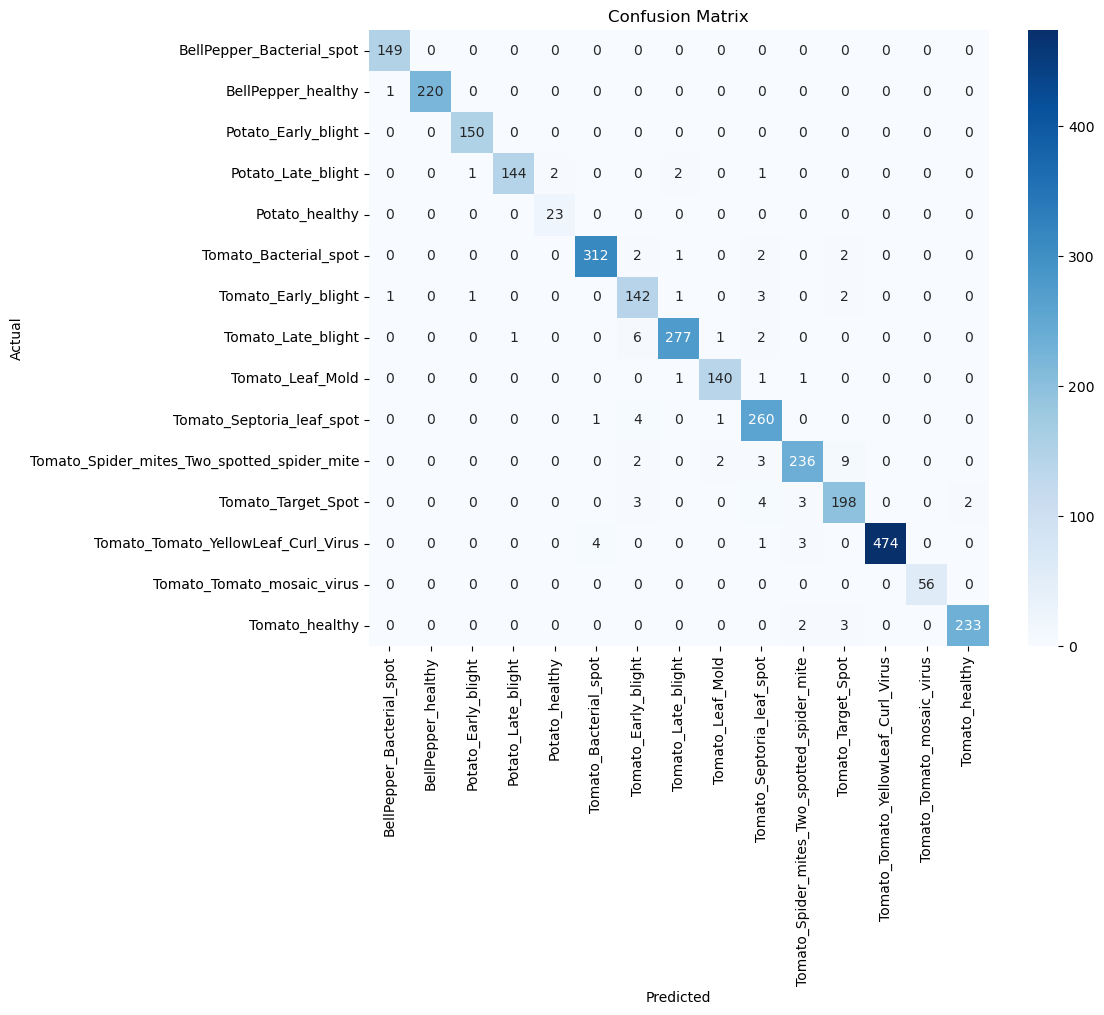

In [22]:
# Load the best model weights before validation
model.load_state_dict(torch.load(best_model_path, weights_only=True))
print("Loaded best model weights from validation.")

# Test loop
model.eval()
test_loss = 0.0
correct = 0
total = 0

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predictions and actual labels
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        # Calculate accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Adding metrics of interest
avg_test_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total
print(f"Test Loss: {avg_test_loss:.4f} \nAccuracy: {accuracy:.2f}%")

# Calculate precision, F1 score, and confusion matrix
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Precision: {precision:.4f} \nRecall: {recall:.4f} \nF1 Score: {f1:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()